# Import Dependencies

In [792]:
# from utils import * # backend file
# from dotenv import load_dotenv # load config
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.covariance import ShrunkCovariance,\
	empirical_covariance, log_likelihood
from scipy import linalg
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import QuantileTransformer
from pypfopt import black_litterman, risk_models, \
    BlackLittermanModel, plotting, DiscreteAllocation, \
    EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load
from scipy.stats import linregress
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

In [793]:
# load_dotenv()

In [794]:
# username = int(os.getenv('MT5_USERNAME'))
# password = os.getenv('MT5_PASSWORD')
# server = os.getenv('MT5_SERVER')
# api_key = os.getenv('BINANCE_API')
# api_secret = os.getenv('BINANCE_SECRET_API')

In [795]:
# datafetcher = DataFetcher(username, password, server, api_key, api_secret)
# dataprocessor = DataProcessor()

In [796]:
# datafetcher.get_investor_data()

# Instruments List

In [797]:
tickers_dict = {
    "us_tech_stocks": ['ADBE', 'AMD', 'MSFT', 'AAPL', 'CRM', 'IBM', 'TSLA', 'META', 'NFLX', 'ORCL', 'NVDA', 'MCHP'],
    "renewables": ['OLED' ,'ENEL.MI', 'FSLR', 'PCG', 'DUK', 'NEE', 'PEG', 'DAR'],
}

# Historical Bars

In [798]:
def yfinance_adj_close(tickers, start=None, end=None, period='1mo', interval='1d'):
    if isinstance(tickers, str):
        tickers = [tickers]

    try:
        if start and end:
            print(f"Fetching data for {tickers} from {start} to {end} with interval '{interval}'")
            data = yf.download(tickers, start=start, end=end, interval=interval)
        else:
            print(f"Fetching data for {tickers} with period '{period}' and interval '{interval}'")
            data = yf.download(tickers, period=period, interval=interval)
        
        if "Adj Close" in data.columns:
            return data["Adj Close"]
        else:
            print("Warning: 'Adj Close' data not available, returning full dataset.")
        return data
    except Exception as e:
        print(f"Error while fetching data: {e}")
        return None

In [799]:
all_data = {}
start_date = '2018-01-01'
end_date = '2023-12-01'

for category, tickers in tickers_dict.items():
    print(f"Fetching data for category: {category}")
    all_data[category] = yfinance_adj_close(tickers, start=start_date, end=end_date)

df = pd.concat(all_data.values(), axis=1)
df.ffill(inplace=True)
df.bfill(inplace=True)
df

[************          25%%                      ]  3 of 12 completed

Fetching data for category: us_tech_stocks
Fetching data for ['ADBE', 'AMD', 'MSFT', 'AAPL', 'CRM', 'IBM', 'TSLA', 'META', 'NFLX', 'ORCL', 'NVDA', 'MCHP'] from 2018-01-01 to 2023-12-01 with interval '1d'


[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  8 of 8 completed

Fetching data for category: renewables
Fetching data for ['OLED', 'ENEL.MI', 'FSLR', 'PCG', 'DUK', 'NEE', 'PEG', 'DAR'] from 2018-01-01 to 2023-12-01 with interval '1d'


Ticker,AAPL,ADBE,AMD,CRM,IBM,MCHP,META,MSFT,NFLX,NVDA,ORCL,TSLA,DAR,DUK,ENEL.MI,FSLR,NEE,OLED,PCG,PEG
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.524345,177.699997,10.980000,103.948547,106.689568,40.192986,180.875397,79.633507,201.070007,4.930220,41.771626,21.368668,18.309999,62.175232,3.410852,70.430000,32.770107,167.332108,44.390045,40.448616
2018-01-03,40.517281,181.039993,11.550000,104.824646,109.622269,40.797585,184.115646,80.004112,205.050003,5.254698,42.739105,21.150000,18.240000,61.981007,3.394149,69.800003,32.074940,173.736481,43.671665,40.242416
2018-01-04,40.705494,183.220001,12.120000,106.208496,111.842506,40.895393,183.776672,80.708275,205.630005,5.282398,43.160137,20.974667,18.420000,61.495426,3.501051,69.139999,31.910128,169.980576,43.422222,39.060669
2018-01-05,41.168930,185.339996,11.880000,107.622231,112.388908,41.015427,186.289108,81.708893,209.990005,5.327161,43.419907,21.105333,18.200001,61.211552,3.567865,69.169998,32.055923,172.677109,44.190495,39.385849
2018-01-08,41.016010,185.039993,12.280000,108.378868,113.066742,41.175476,187.714813,81.792305,212.050003,5.490388,43.876774,22.427334,18.389999,61.405769,3.557842,69.620003,32.320049,187.652771,45.128380,39.504814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,189.043869,619.429993,122.309998,223.388290,149.765961,81.410492,337.214691,374.628540,479.559998,47.761551,114.845558,235.449997,43.299999,87.180229,6.009182,154.380005,55.921597,164.117722,17.979515,62.915550
2023-11-27,188.864731,619.270020,122.650002,223.796478,150.142380,79.943810,333.695282,375.799805,479.170013,48.227406,115.062897,236.080002,41.779999,87.362770,6.026046,154.649994,55.950748,166.527725,17.859785,62.287270
2023-11-28,189.471756,623.320007,122.010002,223.925903,150.219559,80.002487,337.972382,379.859467,479.000000,47.806534,114.835678,246.720001,41.549999,87.554924,6.035415,155.020004,56.514336,167.787262,17.460684,62.248608


## Historical Market Cap

In [800]:
all_caps = {}
start_date = '2018-01-01'
end_date = '2023-12-01'

for category, tickers in tickers_dict.items():
    if category == 'cash_equivalents':
        continue
    
    print(f"Fetching marketCap data for category: {category}")
    market_caps = {}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        
        outstanding_shares = stock.info.get('sharesOutstanding', None)
        
        if outstanding_shares is not None:
            market_cap_series = data['Close'] * outstanding_shares
            market_caps[ticker] = market_cap_series
        else:
            print(f"Warning: {ticker} has no outstanding shares data.")
            market_caps[ticker] = pd.Series([None] * len(data), index=data.index)
    
    all_caps[category] = pd.DataFrame(market_caps)

caps = pd.concat(all_caps.values(), axis=1)
caps.ffill(inplace=True)
caps.bfill(inplace=True)
caps

Fetching marketCap data for category: us_tech_stocks
Fetching marketCap data for category: renewables


,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01 23:00:00+00:00,7.822354e+10,1.781845e+10,5.920656e+11,6.125579e+11,9.937481e+10,9.864997e+10,6.859471e+10,3.943084e+11,8.594898e+10,1.157517e+11,1.207411e+11,2.158403e+10,7.941816e+09,3.463584e+10,7.540095e+09,1.160928e+11,4.802925e+10,6.738845e+10,2.015251e+10,2.912169e+09
2018-01-02 05:00:00+00:00,7.822354e+10,1.781845e+10,5.920656e+11,6.125579e+11,9.937481e+10,9.864997e+10,6.859471e+10,3.943084e+11,8.594898e+10,1.157517e+11,1.207411e+11,2.158403e+10,7.941816e+09,3.463584e+10,7.540095e+09,1.160928e+11,4.802925e+10,6.738845e+10,2.015251e+10,2.912169e+09
2018-01-02 23:00:00+00:00,7.822354e+10,1.781845e+10,5.920656e+11,6.125579e+11,9.937481e+10,9.864997e+10,6.859471e+10,3.943084e+11,8.594898e+10,1.157517e+11,1.207411e+11,2.158403e+10,7.941816e+09,3.446622e+10,7.540095e+09,1.160928e+11,4.802925e+10,6.738845e+10,2.015251e+10,2.912169e+09
2018-01-03 05:00:00+00:00,7.969381e+10,1.874346e+10,5.948210e+11,6.124511e+11,1.002124e+11,1.013617e+11,6.789277e+10,4.013721e+11,8.765026e+10,1.184326e+11,1.286876e+11,2.190871e+10,8.245777e+09,3.446622e+10,7.472649e+09,1.142141e+11,4.787921e+10,6.595891e+10,2.004978e+10,2.901035e+09
2018-01-03 23:00:00+00:00,7.969381e+10,1.874346e+10,5.948210e+11,6.124511e+11,1.002124e+11,1.013617e+11,6.789277e+10,4.013721e+11,8.765026e+10,1.184326e+11,1.286876e+11,2.190871e+10,8.245777e+09,3.555177e+10,7.472649e+09,1.142141e+11,4.787921e+10,6.595891e+10,2.004978e+10,2.901035e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28 05:00:00+00:00,2.743855e+11,1.979990e+11,2.824210e+12,2.864017e+12,2.140732e+11,1.388998e+11,7.919860e+11,7.367798e+11,2.047524e+11,3.182166e+11,1.170782e+12,4.296213e+10,7.963418e+09,6.128722e+10,1.659613e+10,4.566475e+10,6.763460e+10,1.162161e+11,3.101381e+10,6.608444e+09
2023-11-28 23:00:00+00:00,2.743855e+11,1.979990e+11,2.824210e+12,2.864017e+12,2.140732e+11,1.388998e+11,7.919860e+11,7.367798e+11,2.047524e+11,3.182166e+11,1.170782e+12,4.296213e+10,7.963418e+09,6.120160e+10,1.659613e+10,4.566475e+10,6.763460e+10,1.162161e+11,3.101381e+10,6.608444e+09
2023-11-29 05:00:00+00:00,2.717751e+11,2.009850e+11,2.795798e+12,2.848524e+12,2.192413e+11,1.395780e+11,7.837041e+11,7.220221e+11,2.039787e+11,3.181344e+11,1.178592e+12,4.357122e+10,8.014726e+09,6.120160e+10,1.664002e+10,4.480365e+10,6.732289e+10,1.166157e+11,3.047926e+10,6.622759e+09


In [801]:
caps_dict = caps.iloc[-1].to_dict()
caps_dict

{'ADBE': 268966606298.82812,
 'AMD': 196619663604.34766,
 'MSFT': 2796240261816.4062,
 'AAPL': 2857248233939.0938,
 'CRM': 239752038940.4297,
 'IBM': 141496616049.79297,
 'TSLA': 770671218360.3555,
 'META': 711046105346.6797,
 'NFLX': 202602261198.2793,
 'ORCL': 318134436858.7383,
 'NVDA': 1145050827204.125,
 'MCHP': 43812766174.0166,
 'OLED': 7964359819.464111,
 'ENEL.MI': 61705828366.731445,
 'FSLR': 16891611109.313965,
 'PCG': 44803648649.6958,
 'DUK': 68488108191.10791,
 'NEE': 116915452221.67969,
 'PEG': 30065095061.48755,
 'DAR': 6977435590.118408}

In [802]:
ticker = "^IRX"

start_date = "2018-01-01"
end_date = "2023-12-01"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2018-01-02,1.378
2018-01-03,1.370
2018-01-04,1.370
2018-01-05,1.370
2018-01-08,1.380
...,...
2023-11-24,5.253
2023-11-27,5.258
2023-11-28,5.260


In [803]:
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

,rf
Date,
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN
2018-01-08,NaN
...,...
2023-11-24,4.941512
2023-11-27,4.945710
2023-11-28,4.950016


# Asset Allocation

## VCV Estimation

In [804]:
selected_tickers = tickers_dict['us_tech_stocks'] + tickers_dict['renewables']

filtered_df = df[selected_tickers]
filtered_df

Ticker,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,177.699997,10.980000,79.633507,40.524345,103.948547,106.689568,21.368668,180.875397,201.070007,41.771626,4.930220,40.192986,167.332108,3.410852,70.430000,44.390045,62.175232,32.770107,40.448616,18.309999
2018-01-03,181.039993,11.550000,80.004112,40.517281,104.824646,109.622269,21.150000,184.115646,205.050003,42.739105,5.254698,40.797585,173.736481,3.394149,69.800003,43.671665,61.981007,32.074940,40.242416,18.240000
2018-01-04,183.220001,12.120000,80.708275,40.705494,106.208496,111.842506,20.974667,183.776672,205.630005,43.160137,5.282398,40.895393,169.980576,3.501051,69.139999,43.422222,61.495426,31.910128,39.060669,18.420000
2018-01-05,185.339996,11.880000,81.708893,41.168930,107.622231,112.388908,21.105333,186.289108,209.990005,43.419907,5.327161,41.015427,172.677109,3.567865,69.169998,44.190495,61.211552,32.055923,39.385849,18.200001
2018-01-08,185.039993,12.280000,81.792305,41.016010,108.378868,113.066742,22.427334,187.714813,212.050003,43.876774,5.490388,41.175476,187.652771,3.557842,69.620003,45.128380,61.405769,32.320049,39.504814,18.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,619.429993,122.309998,374.628540,189.043869,223.388290,149.765961,235.449997,337.214691,479.559998,114.845558,47.761551,81.410492,164.117722,6.009182,154.380005,17.979515,87.180229,55.921597,62.915550,43.299999
2023-11-27,619.270020,122.650002,375.799805,188.864731,223.796478,150.142380,236.080002,333.695282,479.170013,115.062897,48.227406,79.943810,166.527725,6.026046,154.649994,17.859785,87.362770,55.950748,62.287270,41.779999
2023-11-28,623.320007,122.010002,379.859467,189.471756,223.925903,150.219559,246.720001,337.972382,479.000000,114.835678,47.806534,80.002487,167.787262,6.035415,155.020004,17.460684,87.554924,56.514336,62.248608,41.549999


In [805]:
def return_from_prices(prices, log_returns = False):
    if log_returns:
        returns = np.log(1 + prices.pct_change()).dropna(how = 'all')
    else:
        returns = prices.pct_change().dropna(how = 'all')
    return returns

In [806]:
log_returns = return_from_prices(filtered_df, log_returns=True)
log_returns.dropna(inplace=True)
log_returns

Ticker,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Date,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.018621,0.050610,0.004643,-0.000174,0.008393,0.027117,-0.010286,0.017756,0.019601,0.022897,0.063739,0.014930,0.037559,-0.004909,-0.008985,-0.016316,-0.003129,-0.021442,-0.005111,-0.003830
2018-01-04,0.011970,0.048172,0.008763,0.004635,0.013115,0.020051,-0.008325,-0.001843,0.002825,0.009803,0.005258,0.002395,-0.021856,0.031010,-0.009501,-0.005728,-0.007865,-0.005152,-0.029806,0.009820
2018-01-05,0.011504,-0.020001,0.012322,0.011321,0.013223,0.004874,0.006210,0.013579,0.020981,0.006001,0.008438,0.002931,0.015739,0.018904,0.000434,0.017538,-0.004627,0.004559,0.008291,-0.012015
2018-01-08,-0.001620,0.033116,0.001020,-0.003721,0.007006,0.006013,0.060755,0.007624,0.009762,0.010467,0.030180,0.003895,0.083170,-0.002813,0.006485,0.021002,0.003168,0.008206,0.003016,0.010385
2018-01-09,0.008931,-0.038179,-0.000680,-0.000114,0.002660,0.002200,-0.008118,-0.002180,-0.013006,0.005519,-0.000270,-0.001189,0.000000,0.000000,0.005729,-0.008660,-0.011748,-0.007349,-0.003620,-0.003268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,-0.000468,-0.001634,-0.001112,-0.007029,0.002409,0.000322,0.005280,-0.009592,0.003258,0.000086,-0.019484,0.009655,0.000181,0.005002,-0.034005,0.002779,0.004197,0.001391,0.006783,0.001618
2023-11-27,-0.000258,0.002776,0.003122,-0.000948,0.001826,0.002510,0.002672,-0.010492,-0.000814,0.001891,0.009706,-0.018180,0.014578,0.002802,0.001747,-0.006682,0.002092,0.000521,-0.010036,-0.035735
2023-11-28,0.006519,-0.005232,0.010745,0.003209,0.000578,0.000514,0.044083,0.012736,-0.000355,-0.001977,-0.008765,0.000734,0.007535,0.001553,0.002390,-0.022600,0.002197,0.010023,-0.000621,-0.005520


### Scaling

In [807]:
scaler = QuantileTransformer(output_distribution='uniform')
scaled_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

print(scaled_df)


Ticker          ADBE       AMD      MSFT      AAPL       CRM       IBM  \
Date                                                                     
2018-01-02  0.000000  0.017256  0.000817  0.047703  0.000450  0.489491   
2018-01-03  0.000744  0.026902  0.001194  0.047203  0.001228  0.544543   
2018-01-04  0.001361  0.046466  0.001973  0.050669  0.001992  0.585053   
2018-01-05  0.003053  0.037990  0.005901  0.068052  0.004558  0.593489   
2018-01-08  0.002000  0.051415  0.007085  0.065413  0.006706  0.601340   
...              ...       ...       ...       ...       ...       ...   
2023-11-24  0.941716  0.947620  0.995985  0.982127  0.791848  0.997071   
2023-11-27  0.941282  0.950309  0.998141  0.981009  0.794837  0.998048   
2023-11-28  0.949672  0.946167  1.000000  0.984927  0.795829  0.998222   
2023-11-29  0.939145  0.954714  0.998909  0.978470  0.825363  0.999157   
2023-11-30  0.935678  0.943089  0.999007  0.981928  0.917275  1.000000   

Ticker          TSLA      META      N

In [808]:
base_X_train = scaled_df.loc[:'2021-01-01']
base_X_test = scaled_df.loc['2021-01-01':]

In [809]:
noOfFeatures, noOfSamples = 20, 1489
np.random.seed(42)

colorMatrix = np.random.rand(noOfFeatures, noOfFeatures)
X_train = np.dot(base_X_train, colorMatrix)
X_test = np.dot(base_X_test, colorMatrix)

In [810]:
# defining a Spanning range of all possible shrinkage coefficient values
shrinkageFactor = np.logspace(-2, 0, 32)
negative_logliks = [
	-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)\
for s in shrinkageFactor]
realCovariance = np.dot(colorMatrix.T, colorMatrix)
empiricalCovariance = empirical_covariance(X_train)
logRealLikelihood = - \
	log_likelihood(empiricalCovariance, linalg.inv(realCovariance))

# GridSearch method for an optimal shrinkage coefficient
tunedParameters = [{"shrinkage": shrinkageFactor}]
cv = GridSearchCV(ShrunkCovariance(), tunedParameters)
cv.fit(X_train)


GridSearchCV(estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01160155, 0.0134596 , 0.01561523, 0.01811609,
       0.02101748, 0.02438354, 0.02828869, 0.03281928, 0.03807546,
       0.04417345, 0.05124806, 0.05945571, 0.06897785, 0.08002502,
       0.09284145, 0.10771051, 0.12496091, 0.14497407, 0.16819243,
       0.19512934, 0.22638034, 0.26263635, 0.30469896, 0.35349811,
       0.41011271, 0.47579443, 0.55199543, 0.64040043, 0.74296395,
       0.86195357, 1.        ])}])

In [811]:
optimal_shrinkage_coef = cv.best_estimator_.shrinkage
optimal_shrinkage_coef

0.01

In [812]:
# # defining range of shrinkage curve
# plt.loglog(shrinkageFactor,
# 		negative_logliks,
# 		"m--",
# 		label="Negative log-likelihood")

# plt.plot(plt.xlim(),
# 		2 * [logRealLikelihood],
# 		"b-.",
# 		label="Real Covariance Likelihood")

# # Adjusting View in Graph
# maxLikelihood = np.amax(negative_logliks)
# minLikelihood = np.amin(negative_logliks)
# min_y = minLikelihood - 7.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
# max_y = maxLikelihood + 16.0 * np.log(maxLikelihood - minLikelihood)
# min_x = shrinkageFactor[0]
# max_x = shrinkageFactor[-1]

# # Best Covariance estimator likelihood
# plt.vlines(
# 	cv.best_estimator_.shrinkage, min_y,
# 	-cv.best_estimator_.score(X_test),
# 	color="yellow",
# 	linewidth=3,
# 	label="Cross-validation Best estimation",
# )
# #plotting in Graph
# plt.title("Regularized Covariance: Likelihood & Shrinkage Coefficient")
# plt.xlabel("Regularization parameter: Shrinkage coefficient")
# plt.ylabel("Error calculation in negative log-likelihood on test-data")
# plt.ylim(min_y, max_y)
# plt.xlim(min_x, max_x)
# plt.legend()
# plt.show()


In [813]:
from pypfopt.risk_models import CovarianceShrinkage

class CustomCovarianceShrinkage(CovarianceShrinkage):
    def shrunk_covariance(self, delta=0.2):
        return super().shrunk_covariance(delta=optimal_shrinkage_coef)
    
cov_matrix = CustomCovarianceShrinkage(log_returns, True, 252, True).ledoit_wolf()
cov_matrix

Ticker,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Ticker,,,,,,,,,,,,,,,,,,,,
ADBE,0.133000,0.110623,0.083441,0.075179,0.096494,0.035820,0.100218,0.089160,0.089158,0.054834,0.121558,0.087809,0.088003,0.024324,0.059061,0.046889,0.019526,0.034576,0.022165,0.051435
AMD,0.110623,0.293536,0.092547,0.092330,0.101333,0.046008,0.139964,0.103284,0.108661,0.063303,0.195310,0.132466,0.129811,0.029294,0.081014,0.043698,0.017383,0.035848,0.022866,0.065574
MSFT,0.083441,0.092547,0.091113,0.069262,0.075094,0.035268,0.083652,0.076240,0.069616,0.049793,0.104080,0.077107,0.074432,0.022610,0.048455,0.039669,0.022823,0.033343,0.024288,0.045511
AAPL,0.075179,0.092330,0.069262,0.100466,0.067480,0.035750,0.091724,0.075168,0.067650,0.046305,0.100654,0.080924,0.080582,0.021209,0.048870,0.038023,0.023324,0.032713,0.026034,0.046382
CRM,0.096494,0.101333,0.075094,0.067480,0.138922,0.033850,0.098750,0.084351,0.088271,0.049668,0.109721,0.081713,0.082620,0.022504,0.058122,0.043143,0.019814,0.031976,0.023486,0.052226
IBM,0.035820,0.046008,0.035268,0.035750,0.033850,0.069337,0.033216,0.029291,0.020509,0.036063,0.045288,0.052345,0.044027,0.020494,0.029077,0.037068,0.026671,0.024756,0.028280,0.042138
TSLA,0.100218,0.139964,0.083652,0.091724,0.098750,0.033216,0.394102,0.090659,0.106346,0.044206,0.149616,0.112113,0.114479,0.027440,0.097198,0.041363,0.015780,0.037009,0.028769,0.077351
META,0.089160,0.103284,0.076240,0.075168,0.084351,0.029291,0.090659,0.185477,0.097166,0.046446,0.116042,0.087527,0.092389,0.026687,0.052711,0.034086,0.017049,0.029839,0.022377,0.044367
NFLX,0.089158,0.108661,0.069616,0.067650,0.088271,0.020509,0.106346,0.097166,0.219233,0.043067,0.114229,0.075570,0.080041,0.018726,0.059747,0.029396,0.008387,0.025576,0.011747,0.041302


## Black-Litterman Approach

In [814]:
target_prices = pd.read_excel("target_prices.xlsx", sheet_name="Tickers", index_col=0)
target_prices = target_prices[['Target price']]
columns_to_select = filtered_df.columns
target_prices = target_prices[target_prices.index.isin(columns_to_select)]
target_series = target_prices['Target price']
target_series

Ticker
MCHP        96.0
ADBE       465.0
AMD        130.0
MSFT       385.0
AAPL       225.0
CRM        300.0
IBM        145.0
TSLA       260.0
META       420.0
NFLX       510.0
ORCL       135.0
NVDA        67.5
DAR         66.0
OLED       165.0
ENEL.MI      8.1
FSLR       188.0
PCG         20.0
DUK        103.0
NEE         67.0
PEG         70.0
Name: Target price, dtype: float64

In [815]:
start_date = '2018-01-01'
end_date = '2023-12-01'

market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    240.801544
2018-01-03    242.324646
2018-01-04    243.346008
2018-01-05    244.967621
2018-01-08    245.415588
Name: Adj Close, dtype: float64

In [816]:
S = cov_matrix
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.550448034365097

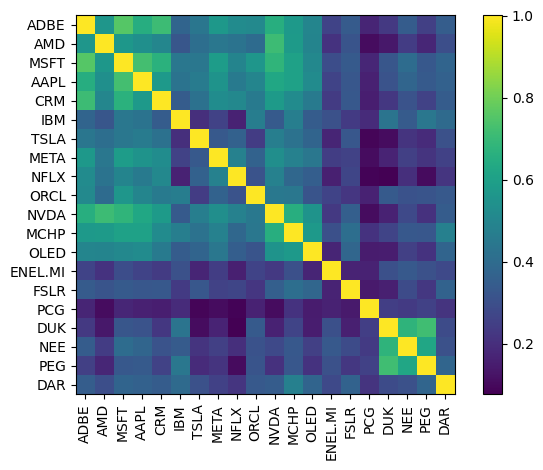

In [817]:
plotting.plot_covariance(S, plot_correlation=True);

In [818]:
market_prior = black_litterman.market_implied_prior_returns(caps_dict, delta, S)
market_prior

Ticker
ADBE       0.239548
AMD        0.300921
MSFT       0.222751
AAPL       0.228882
CRM        0.222319
IBM        0.112216
TSLA       0.317503
META       0.243417
NFLX       0.225389
ORCL       0.148583
NVDA       0.334518
MCHP       0.245409
OLED       0.241409
ENEL.MI    0.081177
FSLR       0.166285
PCG        0.126283
DUK        0.075496
NEE        0.106553
PEG        0.084630
DAR        0.151051
dtype: float64

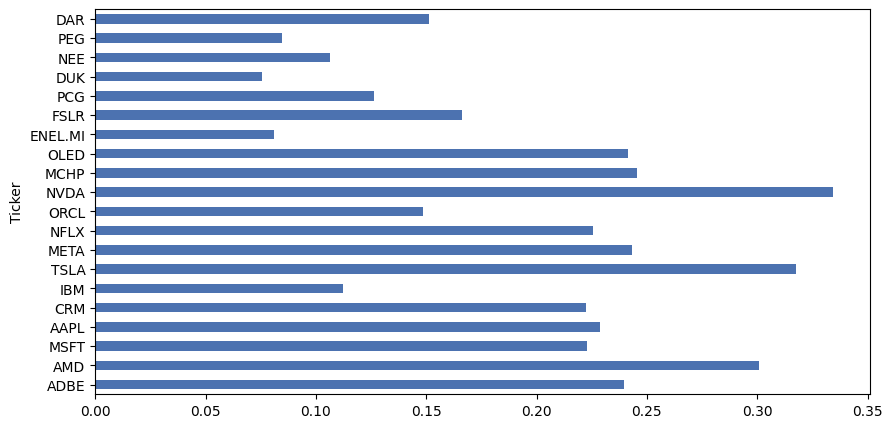

In [819]:
market_prior.plot.barh(figsize=(10,5));

In [820]:
last_row = filtered_df.iloc[-1]
sorted_target = target_series.reindex(last_row.index)
expt_returns = (sorted_target - last_row) / last_row
expt_returns.to_dict()

{'ADBE': -0.23896500455308814,
 'AMD': 0.07296134095987301,
 'MSFT': 0.023670547587566176,
 'AAPL': 0.1903253132862023,
 'CRM': 0.19623591635548154,
 'IBM': -0.05246127021992361,
 'TSLA': 0.08297233429281252,
 'META': 0.2876802124576541,
 'NFLX': 0.07601746668882443,
 'ORCL': 0.17589626377388728,
 'NVDA': 0.44366956177510447,
 'MCHP': 0.1766652271906484,
 'OLED': -0.016728126614585295,
 'ENEL.MI': 0.332973980025947,
 'FSLR': 0.19153252284514816,
 'PCG': 0.1674451482503342,
 'DUK': 0.1617439356038503,
 'NEE': 0.1784481638813831,
 'PEG': 0.1600079550280468,
 'DAR': 0.5044449876207114}

In [821]:
viewdict = expt_returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [822]:
def calculate_confidence(views):
    if abs(views) > 0.3:
        return random.choice([0.7, 0.8, 0.9])
    elif abs(views) > 0.1:
        return random.choice([0.4, 0.5, 0.6])
    else:
        return random.choice([0.1, 0.2, 0.3])
    
confidences = {ticker: calculate_confidence(return_value) for ticker, return_value in viewdict.items()}
confidences = list(confidences.values())
print(confidences)

[0.4, 0.1, 0.3, 0.5, 0.4, 0.2, 0.3, 0.4, 0.2, 0.4, 0.8, 0.4, 0.1, 0.7, 0.5, 0.6, 0.5, 0.4, 0.4, 0.9]


In [823]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

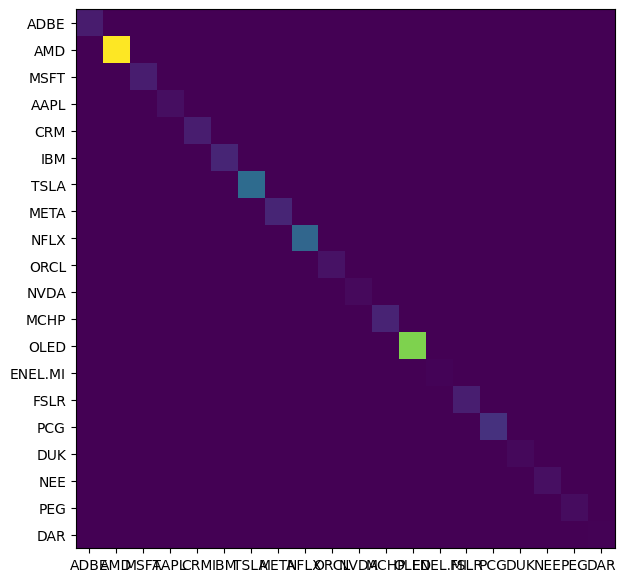

In [824]:

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [825]:
np.diag(bl.omega)

array([0.00997501, 0.132091  , 0.01062981, 0.00502331, 0.01041919,
       0.01386733, 0.04597851, 0.01391078, 0.04384651, 0.00647166,
       0.00321847, 0.01330821, 0.10653406, 0.00139771, 0.01121947,
       0.01861337, 0.00276125, 0.00563694, 0.00442207, 0.00090881])

In [826]:
intervals = []
for confidence in confidences:
    if confidence >= 0.7:
        interval = (confidence - 0.1, confidence + 0.1)
    elif 0.4 <= confidence <= 0.6:
        interval = (confidence - 0.05, confidence + 0.05)
    else:
        interval = (confidence - 0.03, confidence + 0.03)
    
    interval = (max(0, interval[0]), min(1, interval[1]))
    intervals.append(interval)

In [827]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0024999999999999988, 0.0009, 0.0008999999999999982, 0.002500000000000002, 0.0024999999999999988, 0.0009, 0.0008999999999999982, 0.0024999999999999988, 0.0009, 0.0024999999999999988, 0.009999999999999995, 0.0024999999999999988, 0.0009, 0.009999999999999995, 0.002500000000000002, 0.0025000000000000044, 0.002500000000000002, 0.0024999999999999988, 0.0024999999999999988, 0.009999999999999995]


In [828]:
bl = BlackLittermanModel(S, pi="market", market_caps=caps_dict, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [829]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
ADBE      -0.046066
AMD        0.081877
MSFT       0.058836
AAPL       0.141658
CRM        0.129478
IBM       -0.007415
TSLA       0.090927
META       0.227493
NFLX       0.079637
ORCL       0.117608
NVDA       0.215385
MCHP       0.163022
OLED       0.001504
ENEL.MI    0.125305
FSLR       0.171607
PCG        0.164210
DUK        0.121959
NEE        0.143347
PEG        0.132537
DAR        0.245795
dtype: float64

In [830]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
Ticker,,,
ADBE,0.239548,-0.046066,-0.238965
AMD,0.300921,0.081877,0.072961
MSFT,0.222751,0.058836,0.023671
AAPL,0.228882,0.141658,0.190325
CRM,0.222319,0.129478,0.196236
IBM,0.112216,-0.007415,-0.052461
TSLA,0.317503,0.090927,0.082972
META,0.243417,0.227493,0.287680
NFLX,0.225389,0.079637,0.076017


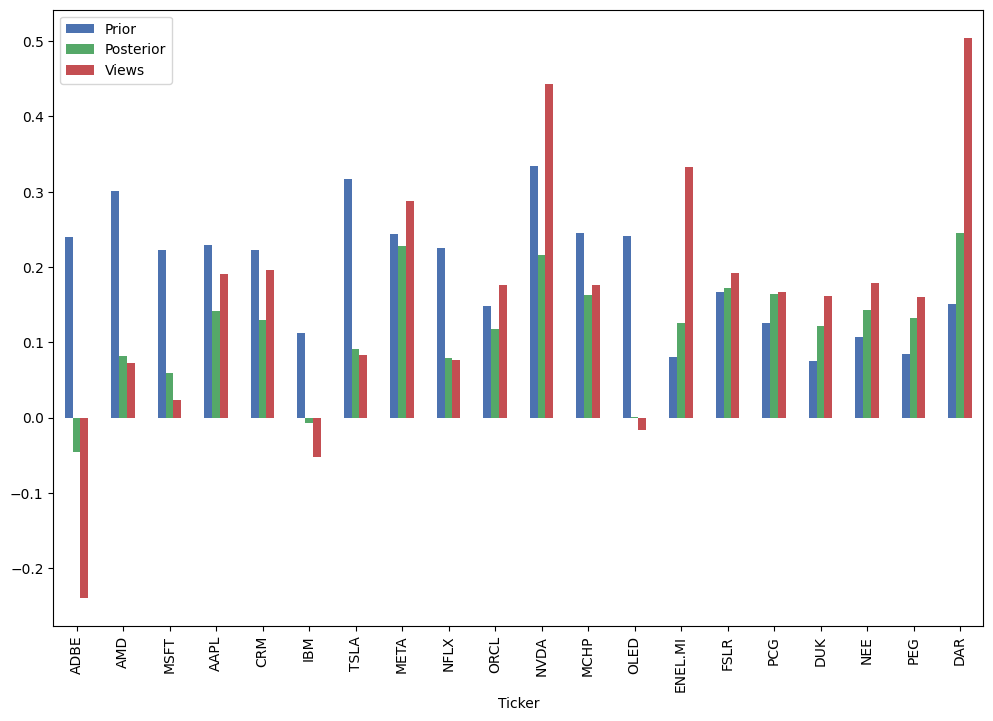

In [831]:
rets_df.plot.bar(figsize=(12,8));

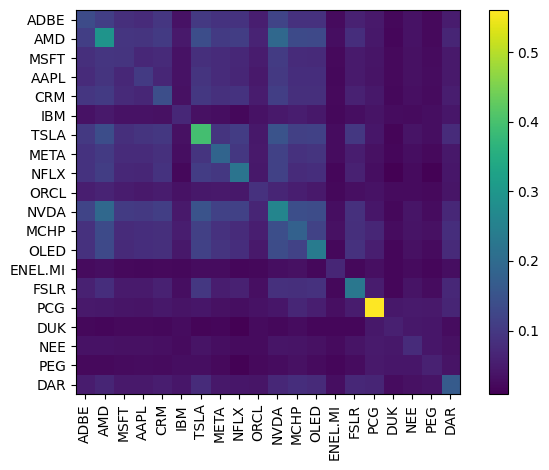

In [832]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [833]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w >= 0.0)
ef.add_constraint(lambda w: w <= 0.10)
us_tech_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
renewable_energy_indices = [12, 13, 14, 15, 16, 17, 18, 19]
ef.add_constraint(lambda w: sum(w[i] for i in us_tech_indices) >= 0.7)
ef.add_constraint(lambda w: sum(w[i] for i in renewable_energy_indices) <= 0.3)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('ADBE', 0.0),
             ('AMD', 0.01616),
             ('MSFT', 0.02522),
             ('AAPL', 0.1),
             ('CRM', 0.09022),
             ('IBM', 0.0),
             ('TSLA', 0.02925),
             ('META', 0.1),
             ('NFLX', 0.03915),
             ('ORCL', 0.1),
             ('NVDA', 0.1),
             ('MCHP', 0.1),
             ('OLED', 0.0),
             ('ENEL.MI', 0.02844),
             ('FSLR', 0.0395),
             ('PCG', 0.03348),
             ('DUK', 0.02686),
             ('NEE', 0.03831),
             ('PEG', 0.03341),
             ('DAR', 0.1)])

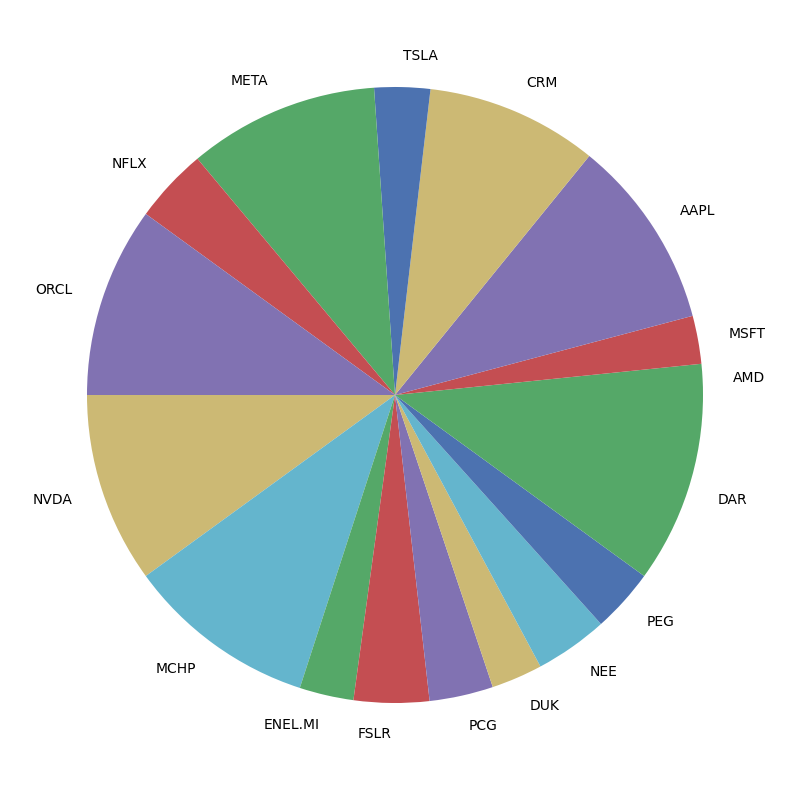

In [834]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [835]:
da = DiscreteAllocation(weights, filtered_df.iloc[-1], total_portfolio_value=400000)
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $19.19


{'AAPL': 211,
 'META': 123,
 'ORCL': 348,
 'NVDA': 855,
 'MCHP': 490,
 'DAR': 911,
 'CRM': 144,
 'FSLR': 100,
 'NFLX': 33,
 'NEE': 269,
 'PCG': 781,
 'PEG': 221,
 'TSLA': 49,
 'ENEL.MI': 1872,
 'DUK': 121,
 'MSFT': 27,
 'AMD': 54}

# Portfolio Theory

In [836]:
stock_list = list(weights.keys())
stock_weights = list(weights.values())
portfolio = filtered_df[stock_list]
portfolio = np.log(portfolio / portfolio.shift(1))
portfolio.dropna(inplace=True)
portfolio

Ticker,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Date,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.018621,0.050610,0.004643,-0.000174,0.008393,0.027117,-0.010286,0.017756,0.019601,0.022897,0.063739,0.014930,0.037559,-0.004909,-0.008985,-0.016316,-0.003129,-0.021442,-0.005111,-0.003830
2018-01-04,0.011970,0.048172,0.008763,0.004635,0.013115,0.020051,-0.008325,-0.001843,0.002825,0.009803,0.005258,0.002395,-0.021856,0.031010,-0.009501,-0.005728,-0.007865,-0.005152,-0.029806,0.009820
2018-01-05,0.011504,-0.020001,0.012322,0.011321,0.013223,0.004874,0.006210,0.013579,0.020981,0.006001,0.008438,0.002931,0.015739,0.018904,0.000434,0.017538,-0.004627,0.004559,0.008291,-0.012015
2018-01-08,-0.001620,0.033116,0.001020,-0.003721,0.007006,0.006013,0.060755,0.007624,0.009762,0.010467,0.030180,0.003895,0.083170,-0.002813,0.006485,0.021002,0.003168,0.008206,0.003016,0.010385
2018-01-09,0.008931,-0.038179,-0.000680,-0.000114,0.002660,0.002200,-0.008118,-0.002180,-0.013006,0.005519,-0.000270,-0.001189,0.000000,0.000000,0.005729,-0.008660,-0.011748,-0.007349,-0.003620,-0.003268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,-0.000468,-0.001634,-0.001112,-0.007029,0.002409,0.000322,0.005280,-0.009592,0.003258,0.000086,-0.019484,0.009655,0.000181,0.005002,-0.034005,0.002779,0.004197,0.001391,0.006783,0.001618
2023-11-27,-0.000258,0.002776,0.003122,-0.000948,0.001826,0.002510,0.002672,-0.010492,-0.000814,0.001891,0.009706,-0.018180,0.014578,0.002802,0.001747,-0.006682,0.002092,0.000521,-0.010036,-0.035735
2023-11-28,0.006519,-0.005232,0.010745,0.003209,0.000578,0.000514,0.044083,0.012736,-0.000355,-0.001977,-0.008765,0.000734,0.007535,0.001553,0.002390,-0.022600,0.002197,0.010023,-0.000621,-0.005520


In [837]:
weights_series = pd.Series(weights)
weighted_returns = portfolio.mul(weights_series, axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
# portfolio_monthly_returns = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
# portfolio_monthly_returns.index = portfolio_monthly_returns.index.strftime('%Y-%m')
# portfolio_monthly_returns

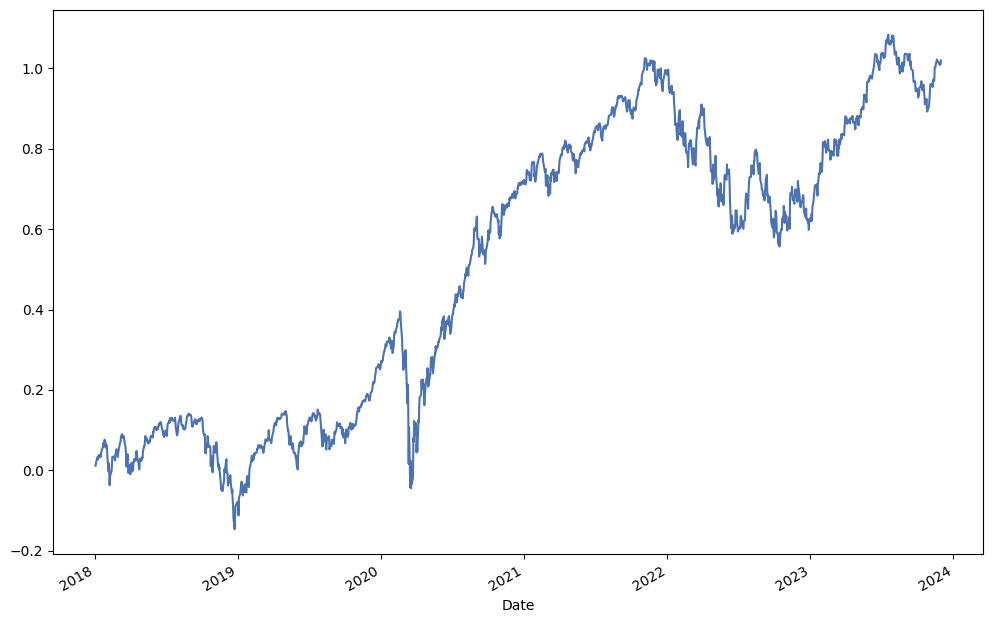

In [838]:
portfolio_returns.cumsum().plot(figsize=(12,8));

In [839]:
def get_factors(factors):
    factor_file = factors + ".csv"
    factor_df = pd.read_csv(factor_file)

    # Rename the first column to 'Date'
    factor_df = factor_df.rename(columns={'Unnamed: 0': 'Date'})

    # Check if the date format is monthly or daily
    if len(str(factor_df['Date'].iloc[0])) == 6:  # YYYYMM format (monthly)
        # Convert the date to YYYY-MM format
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m').strftime('%Y-%m'))
    else:  # Assuming YYYYMMDD format (daily)
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

    # Set the 'Date' column as the index
    factor_df = factor_df.set_index('Date')

    return factor_df

In [840]:
ff_factors_monthly = get_factors("F-F_Research_Data_Factors_daily")
ff_factors_monthly.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009


In [841]:
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(portfolio_returns.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = portfolio_returns - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2018-01-03,0.59,-0.39,-0.18,0.006,0.005573
2018-01-04,0.42,-0.26,0.24,0.006,-0.002033
2018-01-05,0.66,-0.36,-0.26,0.006,0.000678
2018-01-08,0.19,-0.15,0.04,0.006,0.004615
2018-01-09,0.15,-0.34,-0.03,0.006,-0.008073
...,...,...,...,...,...
2023-11-24,0.11,0.59,0.18,0.021,-0.023745
2023-11-27,-0.23,-0.11,-0.08,0.021,-0.026375
2023-11-28,0.06,-0.29,0.05,0.021,-0.019640


In [842]:
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
y = ff_factors_subset["Excess_Return"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1843.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:08:49   Log-Likelihood:                 5004.0
No. Observations:                1488   AIC:                        -1.000e+04
Df Residuals:                    1484   BIC:                            -9979.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.000    -30.390      0.0

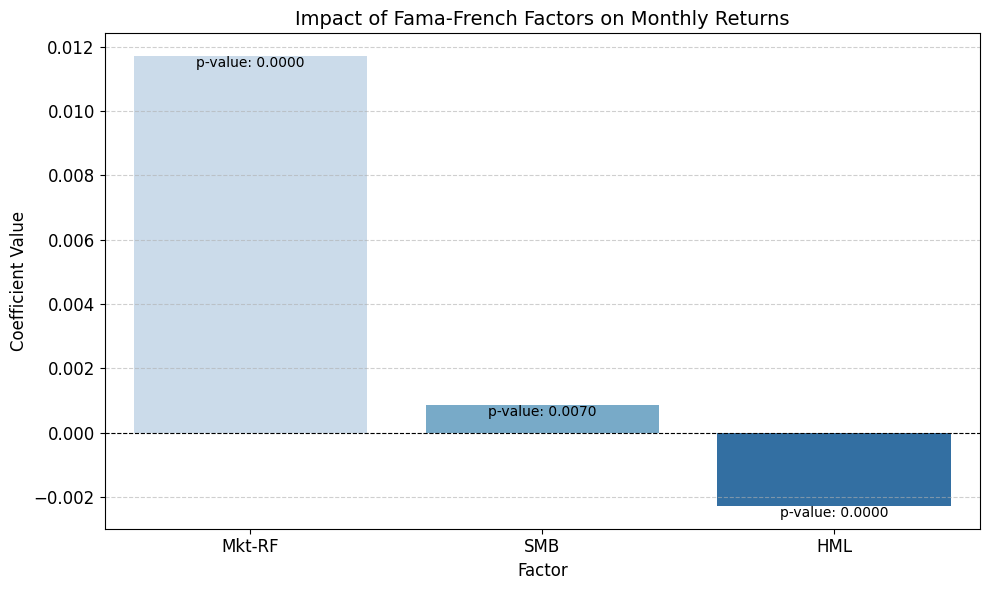

In [ ]:
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

plt.figure(figsize=(10, 6))

sns.barplot(x="Factor", y="Coefficient", data=ols_data, palette="Blues")

for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'],
        f"p-value: {model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="top",
        fontsize=10,
        color="black",
    )

plt.title("Impact of Fama-French Factors on Monthly Returns", fontsize=14)
plt.xlabel("Factor", fontsize=12)
plt.ylabel("Coefficient Value", fontsize=12)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Scenario Analysis

In [19]:
from dataclasses import dataclass
from sensitivity import SensitivityAnalyzer

In [49]:
@dataclass
class ModelInputs:
    starting_salary: int = 75000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.028
    promo_raise: float = 0.16
    savings_rate: float = 0.2
    interest_rate: float = 0.05
    desired_cash: int = 1300000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=75000, promos_every_n_years=5, cost_of_living_raise=0.028, promo_raise=0.16, savings_rate=0.2, interest_rate=0.05, desired_cash=1300000)

In [50]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

In [51]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $77,100.
The salary at year 2 is $79,259.
The salary at year 3 is $81,478.
The salary at year 4 is $83,759.
The salary at year 5 is $99,881.
The salary at year 6 is $102,678.


In [52]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

In [53]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

In [54]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,420.
The wealth at year 2 is $32,043.
The wealth at year 3 is $49,941.
The wealth at year 4 is $69,189.
The wealth at year 5 is $92,625.
The wealth at year 6 is $117,792.


In [55]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [56]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,420.
The wealth at year 2 is $32,043.
The wealth at year 3 is $49,941.
The wealth at year 4 is $69,189.
The wealth at year 5 is $92,625.
The wealth at year 6 is $117,792.
The wealth at year 7 is $144,792.
The wealth at year 8 is $173,734.
The wealth at year 9 is $204,730.
The wealth at year 10 is $241,570.
The wealth at year 11 is $280,996.
The wealth at year 12 is $323,160.
The wealth at year 13 is $368,220.
The wealth at year 14 is $416,341.
The wealth at year 15 is $472,588.
The wealth at year 16 is $532,638.
The wealth at year 17 is $596,711.
The wealth at year 18 is $665,036.
The wealth at year 19 is $737,855.
The wealth at year 20 is $821,931.
The wealth at year 21 is $911,532.
The wealth at year 22 is $1,006,970.
The wealth at year 23 is $1,108,577.
The wealth at year 24 is $1,216,700.
The wealth at year 25 is $1,340,371.

Retirement:
It will take 25 years to retire.


In [57]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
        # Save the results in a tuple for later building the DataFrame
        df_data_tups.append((year, salary, wealth))
        
    # Now we have exited the while loop, so wealth must be >= desired_cash
    
    # Now create the DataFrame
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

In [58]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

In [59]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$77,100.00","$15,420.00"
1,2,"$79,258.80","$32,042.76"
2,3,"$81,478.05","$49,940.51"
3,4,"$83,759.43","$69,189.42"
4,5,"$99,881.45","$92,625.18"
5,6,"$102,678.13","$117,792.06"
6,7,"$105,553.12","$144,792.29"
7,8,"$108,508.60","$173,733.63"
8,9,"$111,546.84","$204,729.67"
9,10,"$133,017.38","$241,569.63"


<Axes: xlabel='Year'>

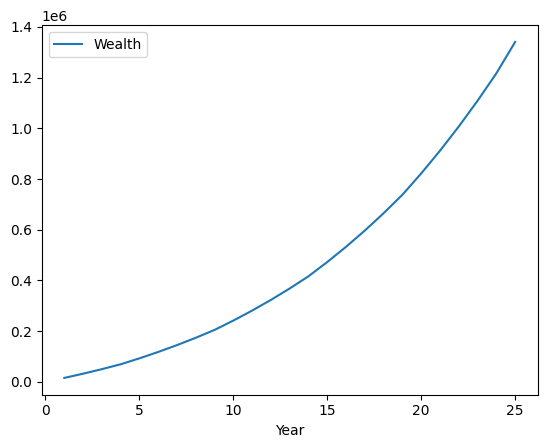

In [60]:
df.plot.line(x='Year', y='Wealth')

<Axes: xlabel='Year'>

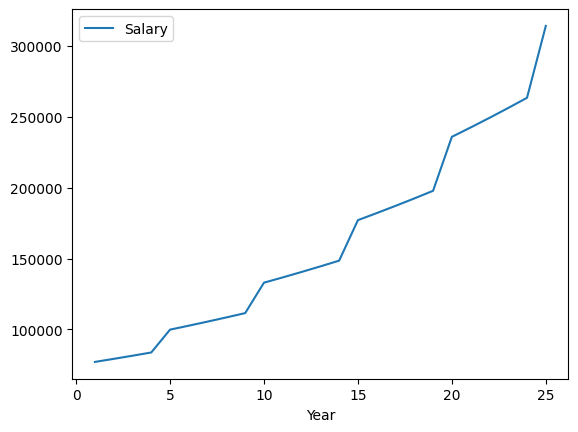

In [61]:
df.plot.line(x='Year', y='Salary')

In [63]:
def years_to_retirement_separate_args(
    starting_salary=75000, promos_every_n_years=5, cost_of_living_raise=0.028, 
    promo_raise=0.16, savings_rate=0.2, interest_rate=0.05, desired_cash=1300000
):
    data = ModelInputs(
        starting_salary=starting_salary, 
        promos_every_n_years=promos_every_n_years, 
        cost_of_living_raise=cost_of_living_raise, 
        promo_raise=promo_raise, 
        savings_rate=savings_rate, 
        interest_rate=interest_rate, 
        desired_cash=desired_cash
    )
    
    return years_to_retirement(data, print_output=False)

years_to_retirement_separate_args()

25

In [64]:
# It is certainly possible to specify all these hard-coded but using list comprehensions makes it easy to adjust
sensitivity_values = {
    'starting_salary': [i * 10000 for i in range(4, 8)],
    'promos_every_n_years': [i for i in range(4, 8)],
    'cost_of_living_raise': [i/100 for i in range(1, 4)],
    'promo_raise': [i/100 for i in range(10, 25, 5)],
    'savings_rate': [i/100 for i in range(10, 50, 10)],
    'interest_rate': [i/100 for i in range(3, 8)],
    'desired_cash': [i * 100000 for i in range(10, 26, 5)]
}

In [65]:
sa = SensitivityAnalyzer(
    sensitivity_values,
    years_to_retirement_separate_args,
    result_name='Years to Retirement',
    reverse_colors=True,
    grid_size=3
)

  0%|          | 0/11520 [00:00<?, ?it/s]

100%|██████████| 11520/11520 [00:06<00:00, 1687.49it/s]


In [66]:
sa.df

,starting_salary,promos_every_n_years,cost_of_living_raise,promo_raise,savings_rate,interest_rate,desired_cash,Years to Retirement
0,40000,4,0.01,0.1,0.1,0.03,1000000,52
1,40000,4,0.01,0.1,0.1,0.03,1500000,60
2,40000,4,0.01,0.1,0.1,0.03,2000000,66
3,40000,4,0.01,0.1,0.1,0.03,2500000,71
4,40000,4,0.01,0.1,0.1,0.04,1000000,47
...,...,...,...,...,...,...,...,...
11515,70000,7,0.03,0.2,0.4,0.06,2500000,25
11516,70000,7,0.03,0.2,0.4,0.07,1000000,16
11517,70000,7,0.03,0.2,0.4,0.07,1500000,19
11518,70000,7,0.03,0.2,0.4,0.07,2000000,22


In [67]:
bad_economy_data = ModelInputs(
    starting_salary=50000,
    promos_every_n_years=8,
    cost_of_living_raise=0.01,
    promo_raise=0.07,
    savings_rate=0.15,
    interest_rate=0.03,
)

good_economy_data = ModelInputs(
    starting_salary=90000,
    promos_every_n_years=4,
    cost_of_living_raise=0.03,
    promo_raise=0.20,
    savings_rate=0.35,
    interest_rate=0.06,
)

cases = {
    'Bad': bad_economy_data,
    'Normal': model_data, # Original inputs were set to assume a normal economy
    'Good': good_economy_data
}

In [68]:
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 52 years to retire in a Bad economy.
It would take 25 years to retire in a Normal economy.
It would take 16 years to retire in a Good economy.


In [69]:
case_probabilities = {
    'Bad': 0.3,
    'Normal': 0.5,
    'Good': 0.2
}

# Take expected value over the cases
expected_ytr = 0
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr += weighted_ytr
print(f'It would take {expected_ytr:.0f} years to retire considering a {case_probabilities["Bad"]:.0%} chance of a bad economy and {case_probabilities["Good"]:.0%} chance of a good economy.')

It would take 31 years to retire considering a 30% chance of a bad economy and 20% chance of a good economy.


# Evaluation

In [845]:
list(portfolio.columns)

['ADBE',
 'AMD',
 'MSFT',
 'AAPL',
 'CRM',
 'IBM',
 'TSLA',
 'META',
 'NFLX',
 'ORCL',
 'NVDA',
 'MCHP',
 'OLED',
 'ENEL.MI',
 'FSLR',
 'PCG',
 'DUK',
 'NEE',
 'PEG',
 'DAR']

In [846]:
port_data = {}
start_date = '2023-12-31'
end_date = '2024-11-26'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    port_data[ticker] = yfinance_adj_close(ticker, start=start_date, end=end_date)

portfolio_df = pd.concat(port_data.values(), axis=1)
portfolio_df.ffill(inplace=True)
portfolio_df.bfill(inplace=True)
portfolio_df.columns = portfolio.columns
portfolio_df

Fetching data for ticker: ADBE
Fetching data for ['ADBE'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AMD
Fetching data for ['AMD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CRM
Fetching data for ['CRM'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: IBM
Fetching data for ['IBM'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: TSLA
Fetching data for ['TSLA'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: META
Fetching data for ['META'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NFLX
Fetching data for ['NFLX'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MCHP
Fetching data for ['MCHP'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: OLED
Fetching data for ['OLED'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ENEL.MI
Fetching data for ['ENEL.MI'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FSLR
Fetching data for ['FSLR'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PCG
Fetching data for ['PCG'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DUK
Fetching data for ['DUK'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NEE
Fetching data for ['NEE'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PEG
Fetching data for ['PEG'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Fetching data for ticker: DAR
Fetching data for ['DAR'] from 2023-12-31 to 2024-11-26 with interval '1d'


Ticker,ADBE,AMD,MSFT,AAPL,CRM,IBM,TSLA,META,NFLX,ORCL,NVDA,MCHP,OLED,ENEL.MI,FSLR,PCG,DUK,NEE,PEG,DAR
Date,,,,,,,,,,,,,,,,,,,,
2024-01-02,580.070007,138.580002,368.117218,184.734985,254.997986,155.865479,248.419998,345.250488,468.500000,102.802834,48.157665,84.637184,185.402496,6.285563,172.160004,18.019497,93.972870,59.827847,60.025604,50.480000
2024-01-03,571.789978,135.320007,367.849274,183.351761,250.726929,154.514313,238.449997,343.435944,470.260010,101.222153,47.558792,82.691391,178.595718,6.207802,167.419998,17.939631,94.904816,60.235970,60.288956,49.009998
2024-01-04,567.049988,136.009995,365.209015,181.023178,250.129593,155.247803,237.929993,346.078003,474.670013,101.350586,47.987705,81.547379,174.213562,6.299616,166.309998,17.680071,94.626198,60.051338,60.269451,48.500000
2024-01-05,564.599976,138.580002,365.020416,180.296707,250.010101,153.607117,237.490005,350.893524,474.059998,101.488907,49.086464,82.124268,175.475525,6.268699,166.869995,17.859768,94.674232,60.323421,60.210922,46.209999
2024-01-08,580.549988,146.179993,371.908905,184.655365,259.717010,155.518021,240.449997,357.583374,485.029999,103.395584,52.241787,83.737625,178.426788,6.285563,166.130005,18.019497,95.490883,61.139648,60.649853,47.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,499.609985,139.389999,416.955414,228.279999,323.429993,210.250000,346.000000,561.090027,871.320007,188.899994,147.009995,64.436150,164.429993,6.643000,187.360001,21.000000,113.580002,76.566864,90.089996,41.799999
2024-11-20,499.500000,137.600006,414.659973,229.000000,325.700012,214.600006,342.029999,565.520020,883.849976,190.750000,145.889999,64.674515,165.899994,6.564000,184.839996,21.100000,113.739998,76.368195,90.489998,41.779999
2024-11-21,504.440002,137.490005,412.869995,228.520004,335.779999,222.399994,339.640015,563.090027,897.479980,192.429993,146.669998,66.055000,167.059998,6.580000,181.949997,21.230000,114.860001,76.845001,92.349998,41.160000


In [847]:
returns_df = portfolio_df.pct_change().dropna()
port_retss = returns_df.sum(axis=1)

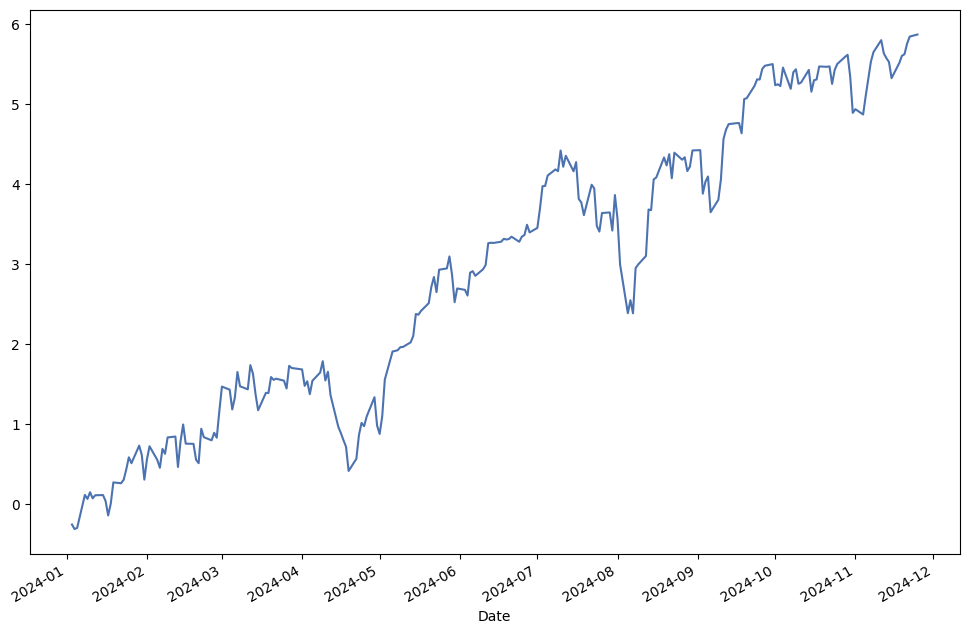

In [848]:
port_retss.cumsum().plot(figsize=(12,8));

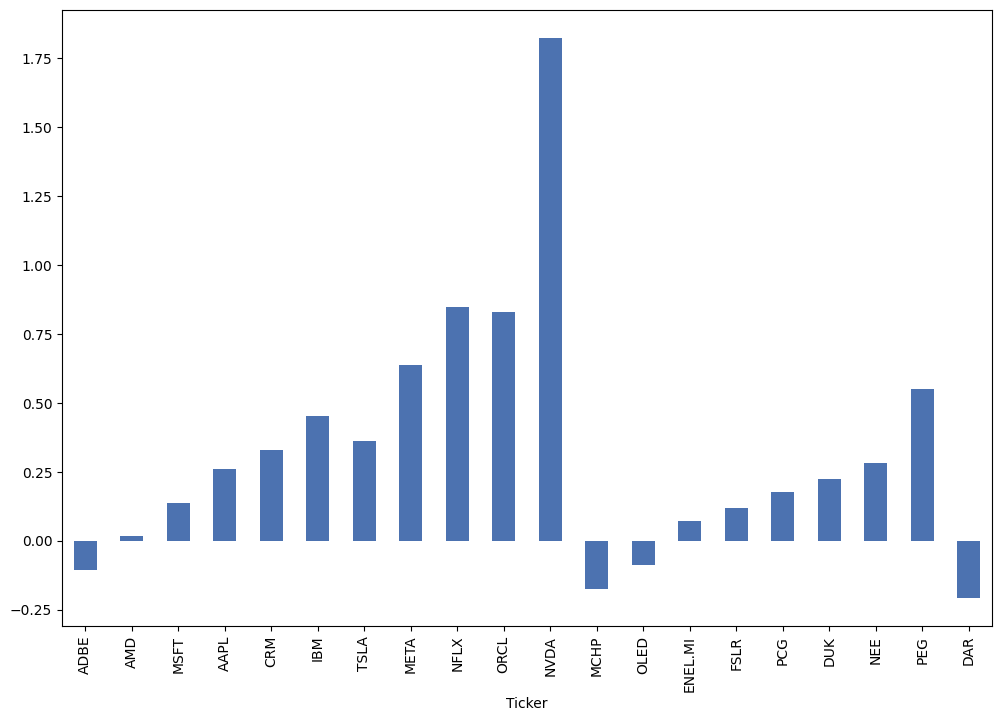

In [849]:
cumulative_returns_df = (1 + returns_df).prod() - 1
cumulative_returns_df.plot(kind='bar', figsize=(12,8));

In [850]:
cumulative_returns_df

Ticker
ADBE      -0.105746
AMD        0.018401
MSFT       0.137654
AAPL       0.260563
CRM        0.329854
IBM        0.450802
TSLA       0.362974
META       0.636812
NFLX       0.847577
ORCL       0.828646
NVDA       1.824473
MCHP      -0.174713
OLED      -0.086636
ENEL.MI    0.072617
FSLR       0.120005
PCG        0.175949
DUK        0.223757
NEE        0.281009
PEG        0.549672
DAR       -0.206815
dtype: float64

In [851]:
ticker = "^IRX"

start_date = "2022-01-01"
end_date = "2024-11-26"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2024-11-19,5.058925
2024-11-20,5.055639
2024-11-21,5.052298


In [852]:
rolling_rf.iloc[-1].values

array([5.0455595])

[*********************100%%**********************]  1 of 1 completed


Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.86
Annualized Jensen Alpha: 2.64%

Attribution Analysis:
Allocation Effects: 0.15%
Selection Effects: 39.70%


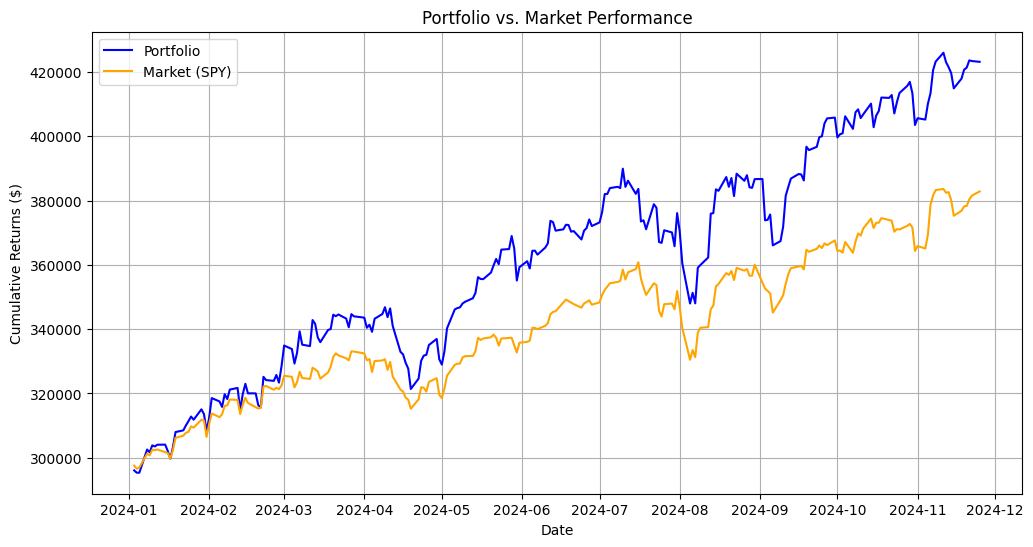

In [853]:
start_date = '2023-12-31'
end_date = '2024-11-26'
# Market data (e.g., S&P 500 as market benchmark)
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]

# Portfolio returns (weighted daily returns based on portfolio_df and stock_weights)
port_retss = (portfolio_df.pct_change() @ stock_weights).dropna()  # Weighted daily returns

# Initial money
initial_money = 300000

# Constants
trading_days_per_year = 252
risk_free_rate_annual = (rolling_rf.iloc[-1].values)/100

# Step 1: Calculate cumulative portfolio returns starting from initial money
portfolio_cum_returns = (1 + port_retss).cumprod() * initial_money  # Adjust cumulative returns

# Step 2: Calculate market returns
market_returns = market_prices.pct_change().dropna()

# Step 3: Sharpe Ratio (Annualized)
risk_free_rate_daily = risk_free_rate_annual / trading_days_per_year
excess_returns = port_retss - risk_free_rate_daily
sharpe_ratio = (excess_returns.mean() * trading_days_per_year) / (port_retss.std() * np.sqrt(trading_days_per_year))

# Step 4: Jensen's Alpha (Annualized)
aligned_market_returns, aligned_port_retss = market_returns.align(port_retss, join='inner')
slope, intercept, _, _, _ = linregress(aligned_market_returns, aligned_port_retss)
jensen_alpha_daily = intercept
jensen_alpha = jensen_alpha_daily * trading_days_per_year

# Step 5: Attribution Analysis
allocation_effects = portfolio_df.pct_change().mean() * stock_weights
selection_effects = aligned_port_retss.mean() * trading_days_per_year - allocation_effects.sum()

# Display Results
print("Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Jensen Alpha: {jensen_alpha:.2%}")

print("\nAttribution Analysis:")
print(f"Allocation Effects: {allocation_effects.sum():.2%}")
print(f"Selection Effects: {selection_effects:.2%}")

# Step 6: Plot Portfolio vs. Market
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label="Portfolio", color="blue")
plt.plot((1 + aligned_market_returns).cumprod() * initial_money, label="Market (SPY)", color="orange")  # Adjusted market cumulative returns
plt.legend()
plt.title("Portfolio vs. Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns ($)")
plt.grid()
plt.show()

In [854]:
beta, _, _, _, _ = linregress(aligned_market_returns, aligned_port_retss)
print(f"Beta: {beta:.2f}")

Beta: 1.34


In [855]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -10.76%


In [856]:
downside_returns = aligned_port_retss[aligned_port_retss < 0]
sortino_ratio = excess_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.17


In [857]:
annualized_return = (portfolio_cum_returns.iloc[-1] / portfolio_cum_returns.iloc[0]) ** (252 / len(aligned_port_retss)) - 1
print(f"Annualized Return: {annualized_return:.2%}")

Annualized Return: 48.66%


In [858]:
correlation = aligned_port_retss.corr(aligned_market_returns)
print(f"Correlation with Market: {correlation:.2f}")

Correlation with Market: 0.91


In [859]:
portfolio_volatility = aligned_port_retss.std() * (252 ** 0.5)  # Annualized volatility
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")

Portfolio Volatility: 18.38%


In [860]:
treynor_ratio = excess_returns.mean() / beta
print(f"Treynor Ratio: {treynor_ratio:.2f}")

Treynor Ratio: 0.00


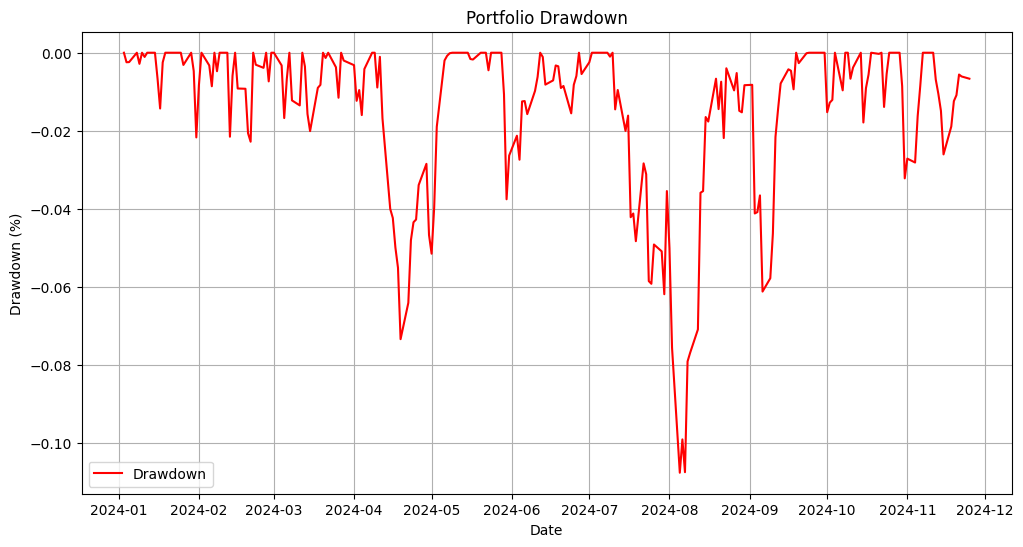

In [861]:
plt.figure(figsize=(12, 6))
plt.plot(drawdown, label="Drawdown", color="red")
plt.title("Portfolio Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid()
plt.legend()
plt.show()

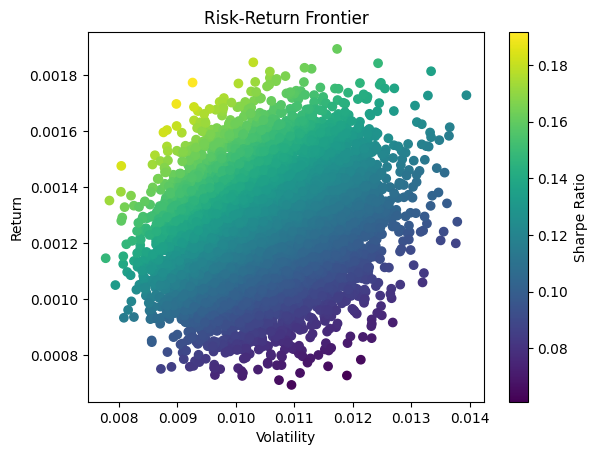

In [862]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Mean returns and covariance matrix for stocks
mean_returns = portfolio_df.pct_change().mean()
cov_matrix = portfolio_df.pct_change().cov()

# Constraints and bounds for optimization (weights sum to 1, each weight is between 0 and 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(len(mean_returns)))

# Random portfolio optimization
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_stddev = portfolio_volatility(weights, mean_returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return / portfolio_stddev)  # Sharpe Ratio

# Plot the efficient frontier
plt.scatter(results[1], results[0], c=results[2], cmap='viridis')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Risk-Return Frontier")
plt.show()